# Model of Housing Prices

### Problem

Predict median housing value for districts in California

**Problem classification**

Considering multiple features, so multiple regression.
Univariate regression, since only trying to predict a single median value for each district.

**Performance Measure**

Root Mean Square Error

In [33]:
#Download the data

from pathlib import Path
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler


In [2]:
def loadHousingData():
    #a tarball is an archive file (.tgz extension)
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok= True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [3]:
housing = loadHousingData()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()
#total bedrooms has 207 null values
#all attributes except ocean_proximity are numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
#can use value_counts to find number of categorical instances
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
#get summary of numerical attributes. null values are ignored.
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

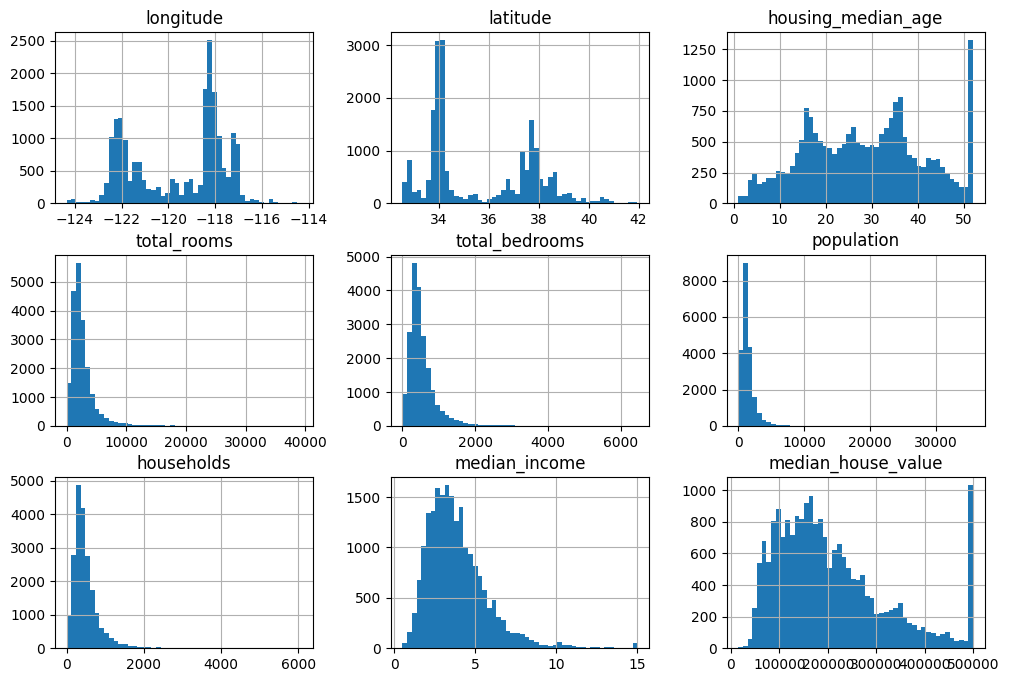

In [8]:
#histogram shows number of instances (on y-axis) with a given value range (on x-axis)

#hist method of matplotlib creates a histogram. Can do this for one feature at a time or on the whole dataset.

housing.hist(bins=50, figsize=(12,8))

## Data Analysis

median income is not expressed in terms of currency but instead has been processed

housing median age and house value have been capped. Need to see if this is a problem - if need to predict values above 500k, then need to collect the proper labels for the capped districts, or remove those districts from the training set.

histograms are also skewed right. this can affect certain ML algos. may want to transform the data such as by computing the log or square root before using ML algos  

In [9]:
#create the test set
def shuffleAndSplitData(data, test_ratio):
    shuffledIndices = np.random.permutation(len(data))
    testSetSize = test_ratio * len(data)
    testIndices = shuffledIndices[:testSetSize]
    trainIndices = shuffledIndices[testSetSize:]
    #use .iloc[] to obtain rows corresponding to relevant indices
    return data.iloc[trainIndices], data.iloc[testIndices]

### Creating a Good Test Set


want to ensure getting the same test set on different runs. could set the seed but the solution breaks when you next fetch an updated dataset.

to ensure a stable train/test split even after updating the dataset, use each instance's identifier to decide whether or not it goes in the test set.

one way to do this is by computing a hash of each instance's identifier, and then putting that instance in the test set if the has is lower than or equal to 20% of the maximum hash value.

In [10]:
#crc32 generates a unique 32-bit checksum for a given set of data


def isIdInTestSet(identifier, testRatio):
    #check if id is in test set
    return crc32(np.int64(identifier)) < testRatio * 2 ** 32

def splitDataWithIdHash(data, testRatio, idColumn):
    #obtain train and test set ids
    ids = data[idColumn]
    inTestSet = ids.apply(lambda id_: isIdInTestSet(id_, testRatio))
    return data.loc[~inTestSet], data.loc[inTestSet]

In [11]:
#in this problem we do not have IDs. 
#might be able to use row index as ID but then you need to make sure new data gets appended to the end of the data set and no row ever gets deleted. 

#reset_index() adds an 'index' column
housingWithId = housing.reset_index()


In [12]:
#can also create a stable unique ID using the features in the dataset, e.g. specific combination of latitude and longitude
housingWithId["id"] = housing["longitude"]*1000 + housing['latitude']
housingWithId
trainSet, testSet = splitDataWithIdHash(housingWithId, 0.2, "id")

In [13]:
#can also do the same with sklearn
trainSet, testSet = train_test_split(housing, test_size=0.2, random_state= 42)


The population is divided into homogeneous subgroups called strata and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population.

In this problem we want to ensure that the test set is representative of the various categories of incomes in the whole dataset. The aim is to create an income category attribute based on the median income. Note that some median incomes go far beyond 6. You need a sufficient number of instances in the dataset for each stratum, or else the estimate of a stratum's importance may be biased. There should not be too many strata, and each stratum should be large enough.

In [14]:
#pd.cut is useful for when you need to sort data values into bins or ranges
#here we divide bins but groups of 1.5units of median income (roughly 15,000USD)
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0,1.5,3,4.5,6,np.inf],
                               labels=[1,2,3,4,5])

Text(0, 0.5, 'Number of districts')

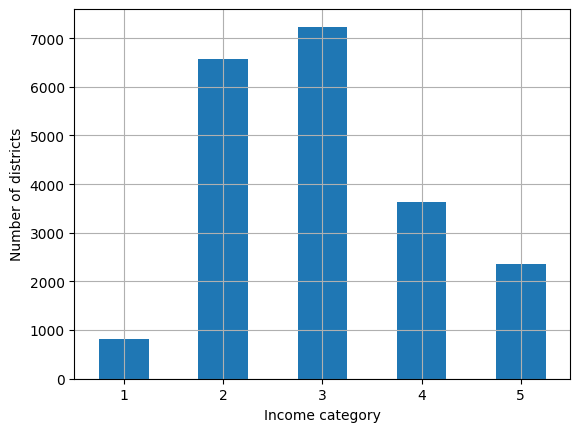

In [15]:
#.sort_index() sorts the indices from low to high
#.plot.bar() gives you a bar chart. rot = 0 causes vertical bars
housing["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)

#add labels with plt.xlabel etc
plt.xlabel("Income category")
plt.ylabel("Number of districts")

In [16]:
#the stratified shuffle split class from sklearn.model_selection has split functions that can be used to generate n different stratified splits of the same dataset.
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state= 42)
stratSplits = []
for trainIndex, testIndex in splitter.split(housing, housing["income_cat"]):
    stratTrainSetN = housing.iloc[trainIndex]
    stratTestSetN = housing.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])


In [17]:
#one can also obtain just a single split using train_test_split:
stratTrainSet, stratTestSet = train_test_split(housing, test_size=0.2,
                                               stratify=housing["income_cat"], random_state=42)

In [18]:
#won't use income category again, so now can drop it from each of the train and test sets
for set_ in (stratTrainSet, stratTestSet):
    set_.drop("income_cat", axis = 1, inplace = True)

Exploratory Data Analysis

In [19]:
#since we will experiment with various transformations of the full training set we can make a copy of the original to revert to afterwards if needed
housing = stratTrainSet.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

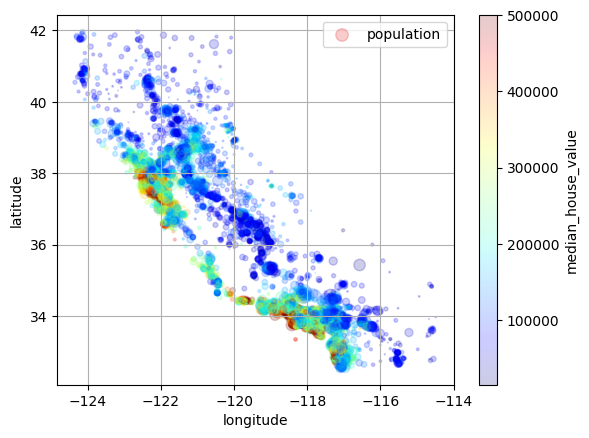

In [20]:
#specify kind="scatter" in the plot function to get a scatter graph
#you can also set the variables for the radius representation with the s parameter and colour representation with the c parameter. 
#the color map is given by the cmap parameter (gives a colour range, e.g. blue for low values and red for large values)

housing.plot(kind = "scatter", x="longitude", y="latitude", s=housing["population"]/100, c = "median_house_value", label = "population", cmap = "jet", colorbar=True, legend = True, sharex= False, grid = True, alpha = 0.2)

In [21]:
#use the .corr() method to find correlations
corr_matrix = housing.corr()
#find correlations with a certain attribute by indexing
corr_matrix["median_house_value"].sort_values(ascending=False)

/var/folders/1q/8vymbqss1bgdgr4kvck49gtw0000gn/T/ipykernel_1676/3776447733.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

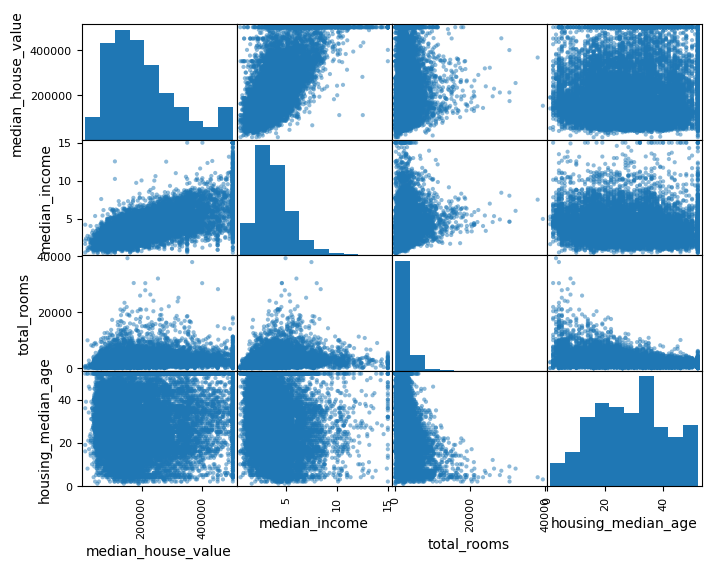

In [22]:
#can also check for correlations between attributes by using the scatter_matrix() function from pandas.plotting
#check only a few relevant attributes rather than the whole matrix to prevent overcomplication

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (8,6))
plt.show()
#looking at the correlation scatterplots, the best attribute to predict median house value is the median income

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

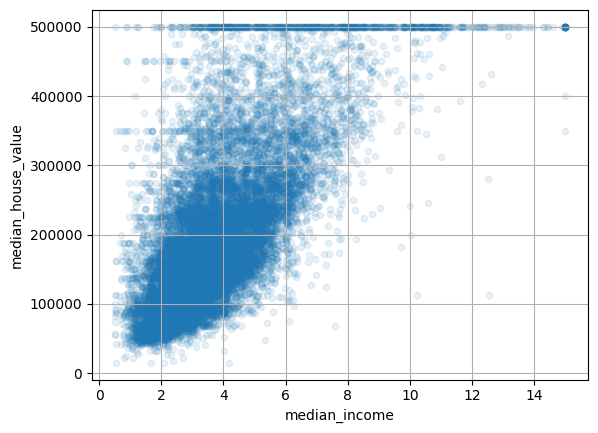

In [23]:
#inspect the relation between median house value and income
housing.plot(kind = "scatter", x="median_income", y="median_house_value", alpha = 0.1, grid = True)
#notice quirks such as horizontal lines in the data that might be due to rounding or price capping. try removing such districts

In [24]:
#you can create new attibutes from combinations of previous attributes, e.g.
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
#and then look at the correlation matrix again
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
#looks like houses with more rooms per house are more expensive understandably
#data exploration is useful to get insights that will help you get a good first prototype.

/var/folders/1q/8vymbqss1bgdgr4kvck49gtw0000gn/T/ipykernel_1676/4227884532.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

**Data Preparation for ML algos**

Obtain clean training set and separate predictors from labels

In [25]:
#Revert to a clean training set and separate the predictors and labels
#.drop() allows you to drop a row (axis = 0) or column (axis = 1) from a COPY of a dataframe
housing = stratTrainSet.drop("median_house_value", axis =1)
#remember .copy() copies a DF
housing_labels = stratTrainSet["median_house_value"].copy()

Clean the Data

Missingness: Remove instances, remove attribute, or set missing values to some value (e.g. zero, mean, median etc - this is 'imputation')
.dropna() and .fillna() can be used to drop instances or fill cells with missing values
here we impute the values for the missing cells of the total bedroom attribute with the median - for example,

median = housing["total_bedrooms"].median()

housing["total_bedrooms"].fillna(median, inplace=True)

Imputation is the least destructive. We will look at imputation here.

In [26]:
#SimpleImputer from sklearn.impute stores the median value of each feature, making it possible to impute missing values not only on the training set, but also on the validation set, test set, and any new data fed to the model.
imputer = SimpleImputer(strategy='median')

#imputers work on number-only data so create a copy of the data with only the numerical attributes
housing_num = housing.select_dtypes(include=[np.number])

#fit the imputer instance to the training data using the fit() method. this is where it computes the median of each attribute
imputer.fit(housing_num)

#now transform the training set using the .transform() method of the imputer
X = imputer.transform(housing_num)

#the output of a sklearn transformer is a numpy array.
#obtain the pandas DataFrame with the column names and index from the original dataframe
housing_tr = pd.DataFrame(X, columns= housing_num.columns, index= housing_num.index)

In [27]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


Dealing with text and categorical attributes

The ocean proximity attribute is textual and categorical. The way to deal with processing categorical values is to turn them into numbers. 
Method 1: You can do this using scikit-learn's OrdinalEncoder class. This is okay when there is an order in the categories, for example, on a range from good to bad. However we cannot use this when the categories are not ordered in this way.
Method 2: Use a OneHotEncoder. This involves the creation of new binary attributes that have a value of 1 when the feature is present and 0 otherwise.

In [28]:
#single brackets outputs a pandas series, while double brackets outputs a pandas dataframe
housingCat = housing[["ocean_proximity"]]
#ordinalEncoder = OrdinalEncoder()
#housing_cat_encoded = ordinalEncoder.fit_transform(housing_cat)

In [29]:
catEncoder = OneHotEncoder()
housingCat1Hot = catEncoder.fit_transform(housingCat)
#the output of a one hot encoder is a scipy sparse matrix (representation for matrices that contains mostly zeros and only stores the nonzero values and their positions)

If a categorical attribute has hundreds or thousands of categories then one-hot encoding results in a very large matrix full of 0s except for a single one per row.

In [30]:
#sparse matrices can be converted to a NumPy array using the .toarray() method
housingCat1Hot.toarray()
#you can also set sparse=False when creating the OneHotEncoder to do this

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Pandas has a function called get_dummies() which converts each categorical feature into a one-hot representation with one binary feature per category.

In contrast, OneHotEncoder remembers which categories it was trained on. When it is used to transform new data, it will remember the attributes of the data it was fitted to and create binary attributes for those. When it detects a category it is not trained on, it raises an exception. You can set the handle_unknown parameter of the OneHotEncoder to "ignore" and it will represent the unknown category with zeros (since it will not be satisfy any of the binary attributes)

When there is a large number of possible categories, you could:
1) Try to replace the categorical input with numerical features related to the categories instead. 
2) You could use one of the encoders provided by the category_encoders package on GitHub.
3) When dealing with NNs, replace each category with a learnable, low-dimensional vector called an embedding.

In [31]:
#sklearn estimators store the column names in the feature_names_in_ attribute.
catEncoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [32]:
#sklearn ensures that any dataframe fed to the estimator has the same column names.
#Transformers also have a get_feature_names_out() method that you can use to build a dataframe around the transformer's output (the binary categories)
catEncoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

# Feature Scaling and Transformation

In [38]:
#Min-max scaling 
minMaxScaler = MinMaxScaler(feature_range=(-1,1))
housingNumMinMaxScaled = minMaxScaler.fit_transform(housing_num)

housingNumMinMaxScaledDf = pd.DataFrame(housingNumMinMaxScaled, columns=minMaxScaler.feature_names_in_)
housingNumMinMaxScaledDf

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-0.608519,0.117021,1.000000,-0.831171,-0.641166,-0.807018,-0.614336,-0.779479
1,0.210953,-0.661702,0.529412,-0.900148,-0.886294,-0.918660,-0.867090,-0.229293
2,-0.519270,0.236170,0.254902,-0.945012,-0.930424,-0.931419,-0.924585,-0.733369
3,0.468560,-0.744681,-0.372549,-0.787782,-0.726204,-0.774015,-0.709166,-0.756983
4,0.257606,-0.740426,0.372549,-0.778015,-0.610243,-0.765796,-0.562815,-0.582171
...,...,...,...,...,...,...,...,...
16507,0.206897,-0.721277,0.568627,-0.886312,-0.808021,-0.885290,-0.805115,-0.419236
16508,0.022312,-0.197872,-0.137255,-0.850298,-0.809631,-0.826279,-0.801755,-0.714018
16509,0.478702,-0.991489,-0.529412,-0.800702,-0.750684,-0.655134,-0.716632,-0.508738
16510,0.206897,-0.678723,0.411765,-0.807773,-0.719117,-0.788738,-0.687512,-0.497166


In [41]:
stdScaler = StandardScaler()
housingNumStdScaled = stdScaler.fit_transform(housing_num)
housingNumStdScaledDf= pd.DataFrame(housingNumStdScaled, columns = stdScaler.feature_names_in_)
housingNumStdScaledDf

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.423037,1.013606,1.861119,0.311912,1.359094,0.137460,1.394812,-0.936491
1,0.596394,-0.702103,0.907630,-0.308620,-0.436356,-0.693771,-0.373485,1.171942
2,-1.203098,1.276119,0.351428,-0.712240,-0.759584,-0.788768,-0.775727,-0.759789
3,1.231216,-0.884924,-0.919891,0.702262,0.736231,0.383175,0.731375,-0.850281
4,0.711362,-0.875549,0.589800,0.790125,1.585590,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
16507,0.586397,-0.833359,0.987087,-0.184147,0.136961,-0.445315,0.060101,0.444041
16508,0.131525,0.319822,-0.443146,0.139847,0.125165,-0.005950,0.083608,-0.685630
16509,1.256209,-1.428701,-1.237721,0.586026,0.556922,1.268299,0.679135,0.101049
16510,0.586397,-0.739605,0.669257,0.522417,0.788136,0.273563,0.882868,0.145396
